Preprocesamiento
- No hace falta estandarizar, no estaría tampoco mal
- Agrupar las binarias (has..) en grupos
  - has_secondary_use (hay que añadir más para las combinaciones)
  - has_superstructure
- geo_level3 o 2 quizás se puedan agrupar en intervalos
- Pasar las categóricas a números ? En sí las letras no tienen significado
- Quizás agrupar la edad en intervalos
- Ver qué hacer con las duplicadas
- Los árboles son robustos al ruido, así que las variables extremadamente 
desbalanceadas no deberían hacer mucho daño. Considerar si quitar o no según el
coste computacional que haya en principio.
- Age de 995 mantenerlo, a ver si el árbol consigue algo del estilo if age>200 ...

- Quizá la distancia, al ser datos del mismo terremoto sea muy relevante. 
Se podría reflejar en una combinación de las has_structure y geom_ids 
(el epicentro estaría por unos valores concretos de geom_id)

-------

- No necesitamos normalizar los datos en árboles. Además, no hacerlo nos ayudará a interpretar
- Se podría reducir el número de instancias de forma aleatoria, pero no parece justo. El desbalanceo hay que tenerlo en cuenta.

Versiones

1. Agrupación de características binarias, no se entrena con las que no deja -> Coste computacional alto
2. Se reducen características correladas y alguna desbalanceada -> Coste computacional alto
3. Reducción de características a 10 con chi2 y reducción de instancias con ENN -> Resultados aceptables en CART, overfitting en C4.5 (árbol muy pequeño y muy grande respectivamente)
    - CART y C4.5 submission 1
4. Idem. pero con 15 -> El desbalanceo en el dataset puede que afecte a los resultados
    1. Conseguir geo1 entero (no somos el experto, a lo mejor no es buena idea)
    - CART submission 2 (empeora, no se sube C4.5)
    - Muchos duplicados con etiquetas distintas -> Resultados malísimos en C4.5 (no era overfitting)
5. Idem. pero con mutual_info_classif
6. El mejor de los anteriores con Tomek Links
7. Vuelta a 2, quitar duplicados, coger pocas instancias y probar con C4.5

In [1]:
################################################################################
# Libraries
################################################################################

import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns

# Preprocesamiento
# from sklearn.preprocessing import Normalizer
# from sklearn.decomposition import PCA
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks, CondensedNearestNeighbour
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTENC

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

In [2]:
################################################################################
# Load data
################################################################################

train_values = pd.read_csv("data/train_values.csv")
test_values  = pd.read_csv("data/test_values.csv")
train_labels = pd.read_csv("data/train_labels.csv")

preprocessed_train = train_values
preprocessed_test = test_values


In [3]:
for i,c in enumerate(preprocessed_train.columns):
    print(i, c)

0 building_id
1 geo_level_1_id
2 geo_level_2_id
3 geo_level_3_id
4 count_floors_pre_eq
5 age
6 area_percentage
7 height_percentage
8 land_surface_condition
9 foundation_type
10 roof_type
11 ground_floor_type
12 other_floor_type
13 position
14 plan_configuration
15 has_superstructure_adobe_mud
16 has_superstructure_mud_mortar_stone
17 has_superstructure_stone_flag
18 has_superstructure_cement_mortar_stone
19 has_superstructure_mud_mortar_brick
20 has_superstructure_cement_mortar_brick
21 has_superstructure_timber
22 has_superstructure_bamboo
23 has_superstructure_rc_non_engineered
24 has_superstructure_rc_engineered
25 has_superstructure_other
26 legal_ownership_status
27 count_families
28 has_secondary_use
29 has_secondary_use_agriculture
30 has_secondary_use_hotel
31 has_secondary_use_rental
32 has_secondary_use_institution
33 has_secondary_use_school
34 has_secondary_use_industry
35 has_secondary_use_health_post
36 has_secondary_use_gov_office
37 has_secondary_use_use_police
38 has_s

### IDEA

Join columns
- 15...25 (has superstructure) (they are not dummy variables, use combination)
- 29...38 (has sencondary use) (probably dummy variables)

Remove 28, not needed

Reorder numerics next to numerics

In [4]:
# No hay duplicados en los ids, se pueden quitar
# preprocessed_train.building_id.duplicated

preprocessed_train = preprocessed_train.drop(columns="building_id")
preprocessed_test = preprocessed_test.drop(columns="building_id")

# Lo mismo con las etiquetas
train_labels = train_labels.drop(columns="building_id")

In [5]:
############################################################################
# Preprocesado Nº 2
############################################################################

# Quitamos geo_2 y geo_3. Tienen demasiadas categorías diferentes para los árboles,
# y no se solapan
preprocessed_train = preprocessed_train.drop(columns=["geo_level_2_id","geo_level_3_id"])
preprocessed_test = preprocessed_test.drop(columns=["geo_level_2_id","geo_level_3_id"])


# En estas dos predomina (+85%) una clase y el resto no sirve para determinar
# ninguna etiqueta (se mantiene la proporción o las 3 están representadas)
preprocessed_train = preprocessed_train.drop(columns=["plan_configuration","legal_ownership_status"])
preprocessed_test = preprocessed_test.drop(columns=["plan_configuration","legal_ownership_status"])

In [6]:
# Altura y nº de plantas altamente correladas, categorizamos nº de plantas y quitamos altura
# Solo una instancia con 9 plantas, y las anteriores no siguen el mismo patrón (que todas sufrieran el mismo tipo de daño)
# Como tenemos proporciones muy similares, juntamos las +5 con ella
preprocessed_train["count_floors_pre_eq"] = preprocessed_train["count_floors_pre_eq"].replace({6:5, 7:5, 8:5, 9:5})
preprocessed_test["count_floors_pre_eq"] = preprocessed_test["count_floors_pre_eq"].replace({6:5, 7:5, 8:5, 9:5})

# No nos interesan variables numéricas en los árboles, acabarían discretizándose
preprocessed_train = preprocessed_train.drop(columns=["height_percentage"])
preprocessed_test = preprocessed_test.drop(columns=["height_percentage"])


In [7]:
preprocessed_train

,geo_level_1_id,count_floors_pre_eq,age,area_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,6,2,30,6,t,r,n,f,q,t,...,0,0,0,0,0,0,0,0,0,0
1,8,2,10,8,o,r,n,x,q,s,...,0,0,0,0,0,0,0,0,0,0
2,21,2,10,5,t,r,n,f,x,t,...,0,0,0,0,0,0,0,0,0,0
3,22,2,10,6,t,r,n,f,x,s,...,0,0,0,0,0,0,0,0,0,0
4,11,3,30,8,t,r,n,f,x,s,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,25,1,55,6,n,r,n,f,j,s,...,0,0,0,0,0,0,0,0,0,0
260597,17,2,0,6,t,r,n,f,q,s,...,0,0,0,0,0,0,0,0,0,0
260598,17,3,55,6,t,r,q,f,q,s,...,0,0,0,0,0,0,0,0,0,0
260599,26,2,10,14,t,r,x,v,s,j,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Eliminar duplicados (HAY QUE REDUCIR LAS ETIQUETAS TAMBIÉ)
df = preprocessed_train.join(train_labels["damage_grade"])
df = df.drop_duplicates()
preprocessed_train = df.drop(columns=["damage_grade"])
train_labels = df["damage_grade"]

# preprocessed_train
# sum(df.loc[:,df.columns != "damage_grade"].duplicated())    # 18303 duplicados sin etiquetas

# Probar (para verlo, en sí voy a quitar los duplicados y listo)
# Unir todas las columnas menos las etiquetas en una
# Ver si en base a esa columna la etiqueta cambia
# https://stackoverflow.com/questions/31903488/python-pandas-identify-duplicate-ids-that-have-conflicting-labels
# df[df.loc[:,df.columns != "damage_grade"].duplicated()]

In [9]:
# One-hot-enconding
label_encoders = {}
categorical_columns = ["geo_level_1_id",
                        # "count_floors_pre_eq",
                        # "age",
                        # "area_percentage",
                        "land_surface_condition",
                        "foundation_type",
                        "roof_type",
                        "ground_floor_type",
                        "other_floor_type",
                        "position",
                        # "count_families",
                        # "has_superstructure",
                        # "has_secondary"
                       ]
for column in categorical_columns:
    # Para training
    dummies = pd.get_dummies(preprocessed_train[column])
    dummies.columns = [column + "_" + str(x) for x in dummies.columns]
    preprocessed_train = preprocessed_train.drop(columns=column)
    preprocessed_train = pd.concat([preprocessed_train, dummies], axis=1)

    # Para test
    dummies = pd.get_dummies(preprocessed_test[column])
    dummies.columns = [column + "_" + str(x) for x in dummies.columns]
    preprocessed_test = preprocessed_test.drop(columns=column)
    preprocessed_test = pd.concat([preprocessed_test, dummies], axis=1)


In [12]:
preprocessed_train

,geo_level_1_id,count_floors_pre_eq,age,area_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,6,2,30,6,t,r,n,f,q,t,...,0,0,0,0,0,0,0,0,0,0
1,8,2,10,8,o,r,n,x,q,s,...,0,0,0,0,0,0,0,0,0,0
2,21,2,10,5,t,r,n,f,x,t,...,0,0,0,0,0,0,0,0,0,0
3,22,2,10,6,t,r,n,f,x,s,...,0,0,0,0,0,0,0,0,0,0
4,11,3,30,8,t,r,n,f,x,s,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260594,27,5,0,13,t,r,n,f,x,j,...,0,0,0,0,0,0,0,0,0,0
260596,25,1,55,6,n,r,n,f,j,s,...,0,0,0,0,0,0,0,0,0,0
260598,17,3,55,6,t,r,q,f,q,s,...,0,0,0,0,0,0,0,0,0,0
260599,26,2,10,14,t,r,x,v,s,j,...,0,0,0,0,0,0,0,0,0,0


In [13]:
for i,c in enumerate(preprocessed_train.columns):
    print(i, c)

0 geo_level_1_id
1 count_floors_pre_eq
2 age
3 area_percentage
4 land_surface_condition
5 foundation_type
6 roof_type
7 ground_floor_type
8 other_floor_type
9 position
10 has_superstructure_adobe_mud
11 has_superstructure_mud_mortar_stone
12 has_superstructure_stone_flag
13 has_superstructure_cement_mortar_stone
14 has_superstructure_mud_mortar_brick
15 has_superstructure_cement_mortar_brick
16 has_superstructure_timber
17 has_superstructure_bamboo
18 has_superstructure_rc_non_engineered
19 has_superstructure_rc_engineered
20 has_superstructure_other
21 count_families
22 has_secondary_use
23 has_secondary_use_agriculture
24 has_secondary_use_hotel
25 has_secondary_use_rental
26 has_secondary_use_institution
27 has_secondary_use_school
28 has_secondary_use_industry
29 has_secondary_use_health_post
30 has_secondary_use_gov_office
31 has_secondary_use_use_police
32 has_secondary_use_other


In [12]:
# v7 - SMOTE + ENN
# Oversampling de todas las clases inferiores, undersampling de puntos ruidosos
sme = SMOTEENN(random_state=42)
print('Original dataset shape %s' % len(train_labels))
X_res, y_res = sme.fit_resample(preprocessed_train, train_labels)
print('Resampled dataset shape %s' % len(y_res))


Original dataset shape 179275
Resampled dataset shape 125377


In [17]:
preprocessed_train = pd.DataFrame(X_res)
train_labels = pd.DataFrame(y_res)

In [20]:
train_labels.value_counts()

damage_grade
1               75398
3               39579
2               10400
dtype: int64

In [9]:
# PROBAR CON SMOTENC
# v8 Con onehot
# categorical = list(range(0,len(preprocessed_train.columns)))
# categorical.remove(14)
# categorical = categorical[3:]

# v9 SIN ONEHOT
categorical = list(range(0,len(preprocessed_train.columns)))
categorical.remove(1)
categorical.remove(2)
categorical.remove(3)
categorical.remove(21)

sm_nc = SMOTENC(categorical_features=categorical, random_state=0)
print('Original dataset shape %s' % len(train_labels))
x_smnc, y_smnc = sm_nc.fit_resample(preprocessed_train, train_labels)
print('Resampled dataset shape %s' % len(y_smnc))

Original dataset shape 179275
Resampled dataset shape 302703


In [10]:
preprocessed_train = pd.DataFrame(x_smnc)
train_labels = pd.DataFrame(y_smnc)

In [11]:
train_labels.value_counts()

damage_grade
3               100901
2               100901
1               100901
dtype: int64

In [24]:
preprocessed_train

,count_floors_pre_eq,age,area_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,...,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t
0,2,30,6,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,2,10,8,0,1,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
2,2,10,5,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,2,10,6,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
4,3,30,8,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302698,2,5,7,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
302699,2,50,3,0,1,1,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
302700,2,55,3,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
302701,2,20,6,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [16]:
#############################################################

In [10]:
# Preprocesado 3.1
# Selección de características
# For classification: chi2, f_classif, mutual_info_classif
# selector = SelectKBest(chi2, k=15)
selector = SelectKBest(mutual_info_classif, k=15)
selector.fit(preprocessed_train, train_labels)
X_new = selector.transform(preprocessed_train)


In [11]:
columns = preprocessed_train.columns[selector.get_support()]
columns

Index(['count_floors_pre_eq', 'age', 'has_superstructure_mud_mortar_stone',
       'has_superstructure_cement_mortar_brick', 'count_families',
       'geo_level_1_id_17', 'geo_level_1_id_26', 'foundation_type_i',
       'foundation_type_r', 'roof_type_n', 'roof_type_x',
       'ground_floor_type_f', 'ground_floor_type_v', 'other_floor_type_q',
       'other_floor_type_s'],
      dtype='object')

In [12]:
# what are scores for the features
pd.DataFrame(selector.scores_).transpose()

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,0.032918,0.033048,0.013741,0.00448,0.06669,0.001536,0.002692,0.00301,0.032034,0.005578,...,0.000234,0.000843,0.014176,0.037567,0.025649,0.001583,0.001856,0.000709,0.015622,0.001171


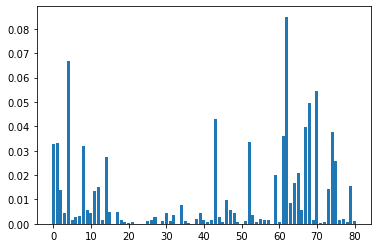

In [13]:
# plot the scores
plt.bar([i for i in range(len(selector.scores_))], selector.scores_)
plt.show()

In [14]:
X_new

array([[ 2, 30,  1, ...,  0,  1,  0],
       [ 2, 10,  1, ...,  0,  1,  0],
       [ 2, 10,  1, ...,  0,  0,  0],
       ...,
       [ 3, 55,  1, ...,  0,  1,  0],
       [ 2, 10,  0, ...,  1,  0,  1],
       [ 3, 10,  1, ...,  0,  1,  0]], dtype=int64)

In [15]:
# define the undersampling method
# Se prueba con los siguiente, no se reduce el desbalanceo (en CNN sí ??)
# USAR MÉTODOS DE SELECCIÓN DE CARACACTERÍSTICAS ANTES, QUIZÁS DECIR QUE GEO1 Y FLOOR... SON LAS QUE SE ELIGEN MEDIANTE UN ARBOL
# MIRAR SMOTE PARA OVERSAMPLING

# Quizás no estaría mal reducir el desbalanceo
# https://stats.stackexchange.com/questions/28029/training-a-decision-tree-against-unbalanced-data
# https://weka.8497.n7.nabble.com/Producing-a-perfect-decision-tree-using-J48-td11751.html

# undersample = TomekLinks()
# undersample = CondensedNearestNeighbour(n_neighbors=1)
undersample = EditedNearestNeighbours(n_neighbors=3)
# transform the dataset
X, y = undersample.fit_resample(X_new, train_labels)

In [16]:
print(len(X))
print(len(X_new))

74973
260601


In [22]:
preprocessed_train = pd.DataFrame(X, columns=columns)
train_labels = y

In [18]:
# Select same feautures as with train
preprocessed_test = selector.transform(preprocessed_test)
preprocessed_test = pd.DataFrame(preprocessed_test, columns=columns)
preprocessed_test

,age,area_percentage,has_superstructure_mud_mortar_stone,has_superstructure_cement_mortar_brick,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,geo_level_1_id_17,geo_level_1_id_26,foundation_type_i,foundation_type_r,foundation_type_w,roof_type_x,ground_floor_type_v,other_floor_type_j,other_floor_type_s
0,20,7,1,0,0,0,1,0,0,1,0,0,0,0,0
1,25,13,1,0,0,0,0,0,0,1,0,0,0,0,0
2,5,4,1,0,0,0,0,0,0,1,0,0,0,0,0
3,0,19,0,1,0,0,0,1,0,1,0,1,1,1,0
4,15,8,1,0,0,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86863,70,20,1,0,0,0,0,0,0,1,0,0,0,0,0
86864,25,6,1,0,0,0,0,0,0,1,0,0,0,0,0
86865,50,3,1,0,0,0,0,0,0,1,0,0,0,1,0
86866,5,9,1,0,0,0,0,0,0,1,0,0,0,0,0


In [25]:
preprocessed_train

,geo_level_1_id,count_floors_pre_eq,age,area_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,6,2,30,6,t,r,n,f,q,t,...,0,0,0,0,0,0,0,0,0,3
1,8,2,10,8,o,r,n,x,q,s,...,0,0,0,0,0,0,0,0,0,2
2,21,2,10,5,t,r,n,f,x,t,...,0,0,0,0,0,0,0,0,0,3
3,22,2,10,6,t,r,n,f,x,s,...,0,0,0,0,0,0,0,0,0,2
4,11,3,30,8,t,r,n,f,x,s,...,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260594,27,5,0,13,t,r,n,f,x,j,...,0,0,0,0,0,0,0,0,0,2
260596,25,1,55,6,n,r,n,f,j,s,...,0,0,0,0,0,0,0,0,0,2
260598,17,3,55,6,t,r,q,f,q,s,...,0,0,0,0,0,0,0,0,0,3
260599,26,2,10,14,t,r,x,v,s,j,...,0,0,0,0,0,0,0,0,0,2


In [24]:
train_labels

0         3
1         2
2         3
3         2
4         3
         ..
260594    2
260596    2
260598    3
260599    2
260600    3
Name: damage_grade, Length: 179275, dtype: int64

In [ ]:
# DESHACER TRANSFORMACIÓN PARA CONSEGUIR GEO1 ??

In [12]:
################################################################################
# Write data
################################################################################
preprocessed_train.to_csv("data/preprocessed_train.csv", index=False)
train_labels.to_csv("data/preprocessed_train_labels.csv", index=False)
preprocessed_test.to_csv("data/preprocessed_test.csv", index=False)

In [ ]:
# https://datascience.stackexchange.com/questions/43444/how-to-evaluate-feature-quality-for-decision-tree-model
# https://machinelearningmastery.com/feature-selection-with-categorical-data/

#####################################################################################################
#####################################################################################################
#####################################################################################################

In [8]:
# Join has_superstructure (binary) columns has strings
# Get selected rows to string
df = preprocessed_train.iloc[:,15:25].astype(str)
df_test = preprocessed_test.iloc[:,15:25].astype(str)

# Join them
preprocessed_train["has_superstructure"] = df.apply(lambda x: ''.join(x), axis=1)
preprocessed_test["has_superstructure"] = df_test.apply(lambda x: ''.join(x), axis=1)

In [9]:
# Join has_secondary (binary) columns has strings
# Get selected rows to string
df = preprocessed_train.iloc[:,29:38].astype(str)
df_test = preprocessed_test.iloc[:,29:38].astype(str)

# Join them
preprocessed_train["has_secondary"] = df.apply(lambda x: ''.join(x), axis=1)
preprocessed_test["has_secondary"] = df_test.apply(lambda x: ''.join(x), axis=1)

In [10]:
# Remove joined columns
removed_cols = list(range(15,26)) + list(range(29,39))
preprocessed_train = preprocessed_train.drop(columns=preprocessed_train.columns[removed_cols])
preprocessed_test = preprocessed_test.drop(columns=preprocessed_test.columns[removed_cols])

preprocessed_train

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,legal_ownership_status,count_families,has_secondary_use,has_superstructure,has_secondary
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,v,1,0,1100000000,000000000
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,v,1,0,0100000000,000000000
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,v,1,0,0100000000,000000000
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,v,1,0,0100001100,000000000
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,v,1,0,1000000000,000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,25,1335,1621,1,55,6,3,n,r,n,f,j,s,q,v,1,0,0100000000,000000000
260597,669485,17,715,2060,2,0,6,5,t,r,n,f,q,s,d,v,1,0,0100000000,000000000
260598,602512,17,51,8163,3,55,6,7,t,r,q,f,q,s,d,v,1,0,0100000000,000000000
260599,151409,26,39,1851,2,10,14,6,t,r,x,v,s,j,d,v,1,0,0000010000,000000000


In [11]:
# Convert new cols to int
# preprocessed_train["has_superstructure"] = preprocessed_train["has_superstructure"].apply(lambda x: int(x,2))
# preprocessed_train["has_secondary"] = preprocessed_train["has_secondary"].apply(lambda x: int(x,2))
# preprocessed_train

In [12]:
# Convert to categorical in order (TODO: KEEP ORIGINAL MAPPING)
# MEJOR: Leerlo como factor en R

# preprocessed_train.has_secondary = preprocessed_train.has_secondary.astype("category").cat.codes
# preprocessed_train.has_superstructure = preprocessed_train.has_superstructure.astype('category').cat.codes

# preprocessed_train

In [14]:
# has_secondary_use is enconded in has_secondary, remove it
preprocessed_train = preprocessed_train.drop(columns="has_secondary_use")
preprocessed_test = preprocessed_test.drop(columns="has_secondary_use")
preprocessed_train

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,legal_ownership_status,count_families,has_superstructure,has_secondary
0,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,v,1,1100000000,000000000
1,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,v,1,0100000000,000000000
2,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,v,1,0100000000,000000000
3,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,v,1,0100001100,000000000
4,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,v,1,1000000000,000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,25,1335,1621,1,55,6,3,n,r,n,f,j,s,q,v,1,0100000000,000000000
260597,17,715,2060,2,0,6,5,t,r,n,f,q,s,d,v,1,0100000000,000000000
260598,17,51,8163,3,55,6,7,t,r,q,f,q,s,d,v,1,0100000000,000000000
260599,26,39,1851,2,10,14,6,t,r,x,v,s,j,d,v,1,0000010000,000000000
